# Data Cleaning 

## Objectives
- Clean dataset in preparation for analysis and modelling

## Inputs 
- outputs/datasets/collection/HousingPrices.csv

## Outputs
- outputs/datasets/cleaned/HousingPrices.csv
- outputs/datasets/cleaned/Test.csv
- outputs/datasets/cleaned/Train.csv

---

## Change working directory

In [1]:
import os 
cwd = os.getcwd()
cwd

'/workspaces/heritage-housing/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(cwd))
print("You set a new current working directory")


You set a new current working directory


In [3]:
cwd = os.getcwd()
cwd

'/workspaces/heritage-housing'

---

## Load data

In [4]:
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/HousingPrices.csv")
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,SalePrice,HouseAge,RemodAge,GarageAge,TotalSF,AboveGradeSF,IsRemodeled,Has2ndFlr,HasPorch,HasDeck
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,208500,22,22,22.0,2566.0,1710.0,0,1,0,0
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,181500,49,49,49.0,2524.0,1262.0,0,0,0,0
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,223500,24,23,24.0,2706.0,1786.0,1,1,0,0
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,140000,110,55,27.0,1717.0,961.0,1,0,0,0
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,250000,25,25,25.0,2290.0,1145.0,0,0,0,0


## Data Exploration

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF',
 'GarageAge']

In [6]:
from ydata_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 25.19it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Assessing Missing Data Levels

In [7]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

In [8]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,235,16.10,object
BsmtFinType1,145,9.93,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageAge,81,5.55,float64
BsmtExposure,38,2.60,object
MasVnrArea,8,0.55,float64


Observations:
- EnclosedPorch and WoodDeckSF have severe levels of missing data. It would be most sensible to drop these fields before any analysis or modelling. 
- Categorical variables with missing data are GarageFinish, BsmtFinType1 and BsmtExposure - we should use a CategoricalImputer for these variables.
- Numerical variables with missing data are LotFrontage, BedroomAbvGr, 2ndFlrSF, GarageAge and MasVnrArea - we should use a MeanMedianImputer or ArbitraryNumberImputer for these variables.

### Assessing which imputer to use on numerical values

In [9]:
%matplotlib inline

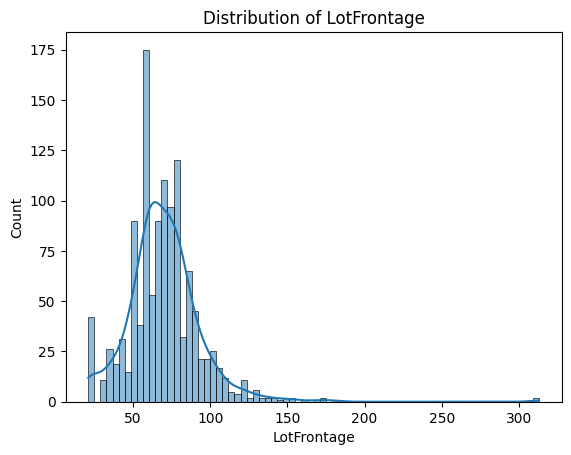

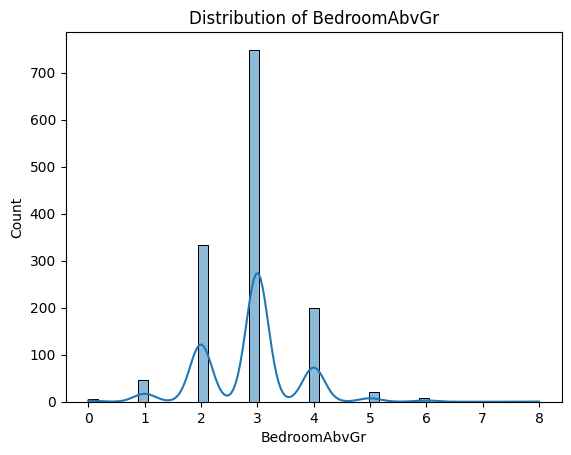

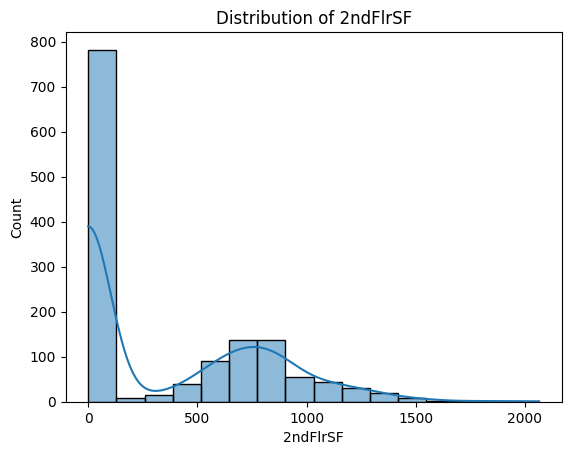

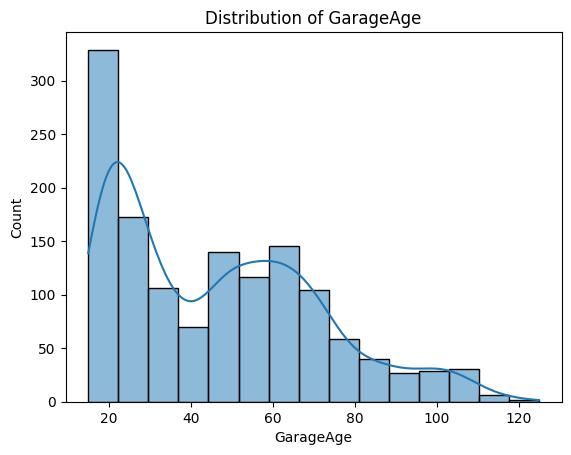

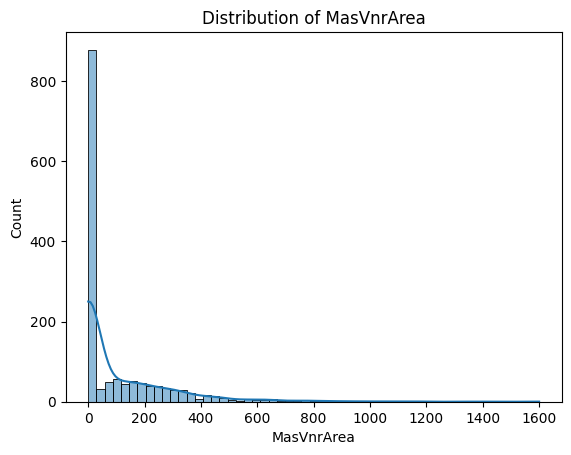

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_variables_missing = ['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageAge', 'MasVnrArea']

for i in numerical_variables_missing:
    sns.histplot(df[i].dropna(), kde=True)
    plt.title(f"Distribution of {i}")
    plt.show()

Observations: 
- 2ndFlrSF and GarageAge can be filled with 0. This will be more meaningful than filling with the median, since it likely represents the lack of 2nd floor/garage.
- It is likely the missing values for LotFrontage, BedroomAbvGr and MasVnrArea are due to data entry missing, rather than the value is 0, so a MeanMedianImputer works best. We will use a median imputer since these variables are not normally distributed. 

## Handling missing data 

In [11]:
from sklearn.preprocessing import FunctionTransformer
from feature_engine.imputation import MeanMedianImputer, ArbitraryNumberImputer, CategoricalImputer
from sklearn.pipeline import Pipeline

In [12]:
cols_to_drop = ['WoodDeckSF', 'EnclosedPorch']

def drop_columns(X):
    return X.drop(columns=cols_to_drop)

dropper = FunctionTransformer(drop_columns)

In [13]:
pipeline = Pipeline([
      ('drop_cols', dropper),
      ( 'median',  MeanMedianImputer(imputation_method='median',
                                     variables=['LotFrontage', 'BedroomAbvGr', 'MasVnrArea']) ),
      ( 'zero_variables',  ArbitraryNumberImputer(arbitrary_number=-0,
                                                  variables=['2ndFlrSF', 'GarageAge']) ),
      ( 'cat_imputer',  CategoricalImputer(imputation_method='missing',
                                          variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure']) )
])
pipeline

Pipeline(steps=[('drop_cols',
                 FunctionTransformer(func=<function drop_columns at 0x7fd3a46d5b20>)),
                ('median',
                 MeanMedianImputer(variables=['LotFrontage', 'BedroomAbvGr',
                                              'MasVnrArea'])),
                ('zero_variables',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'GarageAge'])),
                ('cat_imputer',
                 CategoricalImputer(variables=['GarageFinish', 'BsmtFinType1',
                                               'BsmtExposure']))])

In [14]:
pipeline.fit(df)

Pipeline(steps=[('drop_cols',
                 FunctionTransformer(func=<function drop_columns at 0x7fd3a46d5b20>)),
                ('median',
                 MeanMedianImputer(variables=['LotFrontage', 'BedroomAbvGr',
                                              'MasVnrArea'])),
                ('zero_variables',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'GarageAge'])),
                ('cat_imputer',
                 CategoricalImputer(variables=['GarageFinish', 'BsmtFinType1',
                                               'BsmtExposure']))])

In [15]:
df_clean = pipeline.transform(df)

/home/codespace/.python/current/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):


In [16]:
df_clean.isnull().sum()

1stFlrSF        0
2ndFlrSF        0
BedroomAbvGr    0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinType1    0
BsmtUnfSF       0
GarageArea      0
GarageFinish    0
GrLivArea       0
KitchenQual     0
LotArea         0
LotFrontage     0
MasVnrArea      0
OpenPorchSF     0
OverallCond     0
OverallQual     0
TotalBsmtSF     0
SalePrice       0
HouseAge        0
RemodAge        0
GarageAge       0
TotalSF         0
AboveGradeSF    0
IsRemodeled     0
Has2ndFlr       0
HasPorch        0
HasDeck         0
dtype: int64

In [17]:
print("Imputer dict for median: ", pipeline['median'].imputer_dict_)
print("Imputer dict for zero variables: ", pipeline['zero_variables'].imputer_dict_)
print("Imputer dict for categorical variables: ", pipeline['cat_imputer'].imputer_dict_)

Imputer dict for median:  {'LotFrontage': 69.0, 'BedroomAbvGr': 3.0, 'MasVnrArea': 0.0}
Imputer dict for zero variables:  {'2ndFlrSF': 0, 'GarageAge': 0}
Imputer dict for categorical variables:  {'GarageFinish': 'Missing', 'BsmtFinType1': 'Missing', 'BsmtExposure': 'Missing'}


Observations:
- MasVnrArea median is 0 anyway
- Other variables are being transformed correctly

## Investigating effect of data cleaning pipeline

In [18]:
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageAge', 'MasVnrArea'] 




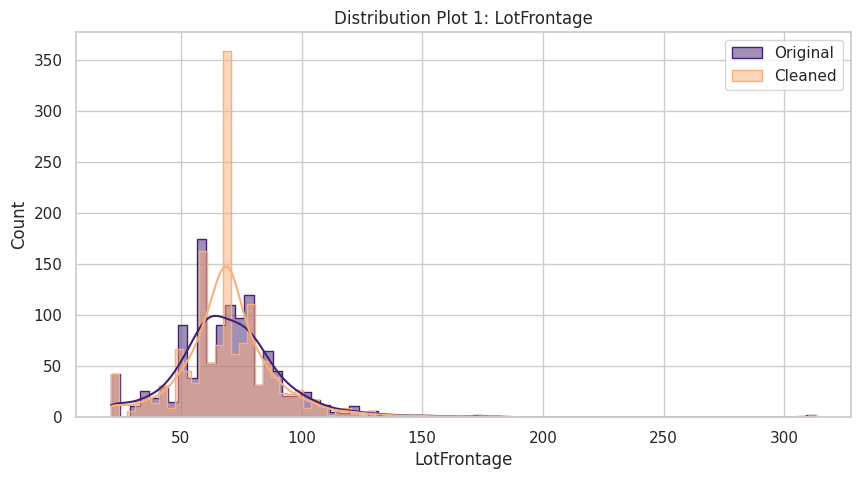

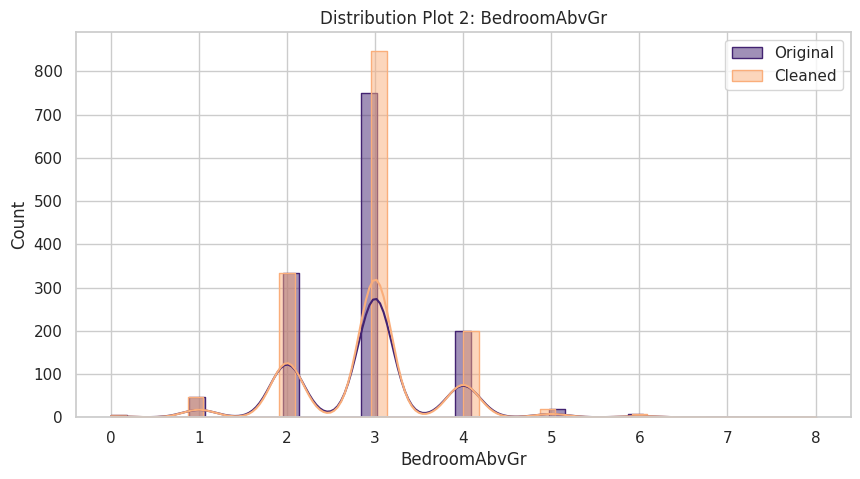

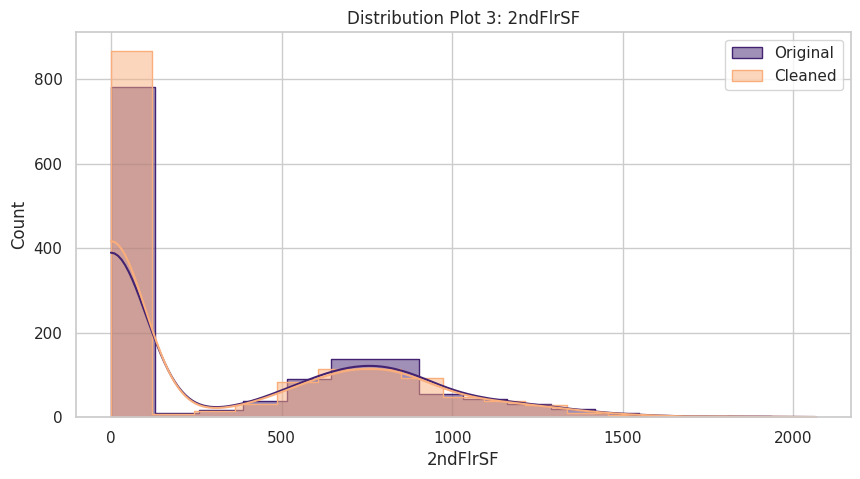

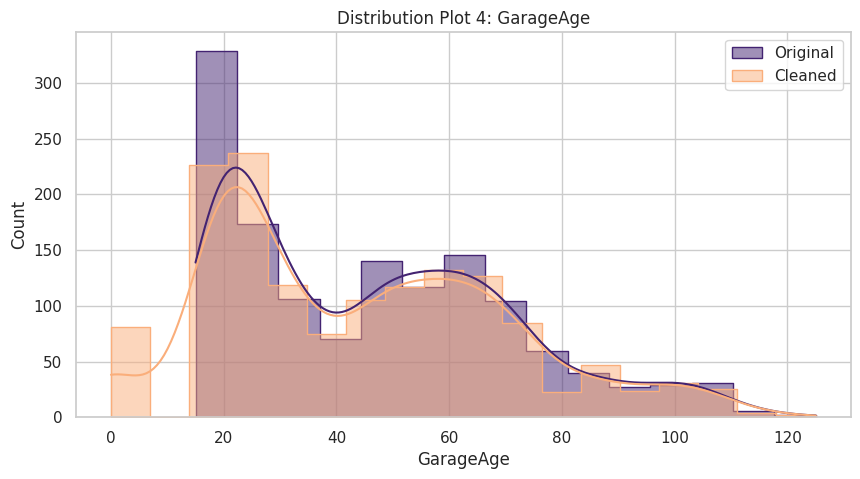

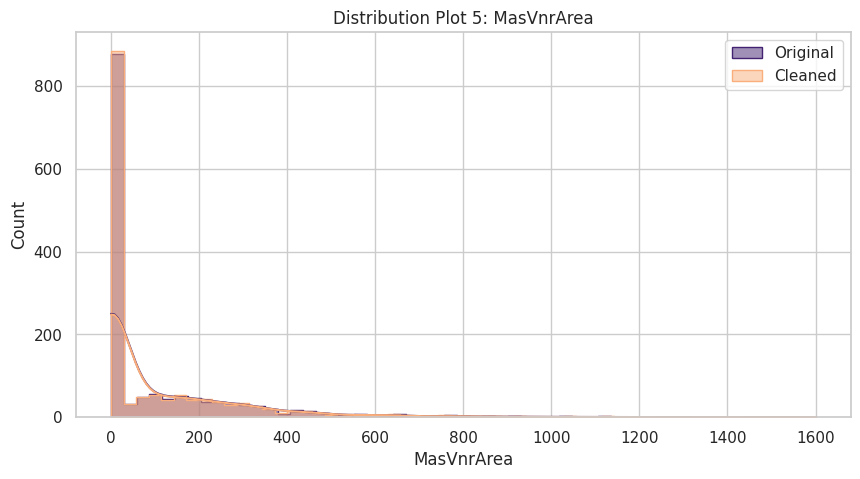

In [19]:
DataCleaningEffect(df_original=df,
                   df_cleaned=df_clean,
                   variables_applied_with_method=numerical_variables_missing)

## Splitting cleaned df into test and train sets

In [20]:
from sklearn.model_selection import train_test_split

X = df_clean
y = df_clean['SalePrice']

X_train, X_test, y_train, y_test= train_test_split(
                                        X,
                                        y,
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {X_train.shape} \nTestSet shape: {X_test.shape}")

TrainSet shape: (1168, 28) 
TestSet shape: (292, 28)


### Checking train set is clean

In [21]:
EvaluateMissingData(X_train)

,RowsWithMissingData,PercentageOfDataset,DataType


## Push cleaned data to repo

In [22]:
from pathlib import Path

out_dir = Path("outputs/datasets/cleaned")
out_dir.mkdir(parents=True, exist_ok=True)

df_clean.to_csv(out_dir / "HousingPrices.csv", index=False)
X_train.to_csv(out_dir / "TrainSetCleaned.csv", index=False)
X_test.to_csv(out_dir / "TestSetCleaned.csv", index=False)